# GeoPython Week - exercise 2
## Table of Contents
- [Define interval](#interval)
- [Split: Train - Validation - Test](#split)
- [Pipeline](#pipeline)

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

# for managing class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import pickle
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# create folder to save models
models_loc='models7wells_2d_1/'
if not os.path.exists(models_loc):
    os.makedirs(models_loc)

In [100]:
# define parameters
interval= True
#interval= False
imbalance = True     # Set true to make use of smote algorithm to manage data inbalance
#imbalance = False
WS_level=0.9
make_gridsearch=True
make_kfold=True
K_folds=5

In [101]:
# read data
#logs=pd.read_csv('data_cleaned1/logs_combined.csv')
logs = pd.read_csv("Data/logs_7wells.csv")
stack_logs=pd.read_csv('data/seismic_7wells.csv')
section_stack_df=pd.read_csv('data/section_2D_1.csv')



In [102]:
stack_logs

,Time,Seismic,log_ID,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr
0,0.0,1.857250e-07,6507_2-4,0.0,0.000003,-1.458270e-07,-0.002556,-3.714510e-08,0.435150,11.2305,0.587815,0.000000e+00,0.002723,0.002723
1,4.0,1.485800e-07,6507_2-4,0.0,0.000003,2.364560e-08,-0.002496,-3.714510e-08,0.424978,11.2305,-0.586274,0.000000e+00,0.002651,0.002651
2,8.0,-4.952680e-08,6507_2-4,0.0,0.000003,-2.943440e-09,-0.002478,-1.981070e-07,0.421835,11.2305,0.573187,-1.609620e-07,0.002629,0.002629
3,12.0,1.981070e-07,6507_2-4,0.0,-0.000003,2.088340e-07,-0.002418,2.476340e-07,0.411794,11.2305,-0.576099,4.457410e-07,0.002558,0.002558
4,16.0,5.262220e-08,6507_2-4,0.0,0.000003,2.766920e-07,-0.002399,-1.454850e-07,0.408441,11.2305,0.564944,-3.931190e-07,0.002535,0.002535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674,3156.0,-1.701137e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5675,3160.0,1.495743e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5676,3164.0,4.436120e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5677,3168.0,5.590646e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
section_stack_df

,Time,DomF,Trace,AppPolr,Seismic,Der,QuadrTrace,SecDerInstAmpl,Integrated,AmpEnv,P_wave,Density,AWF,SecDer,AWCP,InstF,Horison,Imp
0,0.0,2.44141,1.0,0.000000,0.000000,0.000000,0.006623,0.000092,0.039672,0.006610,1479.19,1.20252,0.001842,0.000000,0.001842,6.65428,2D-wb,1778.755559
1,4.0,2.44141,1.0,0.000000,0.000000,0.000000,0.006311,0.000092,0.051413,0.006219,1479.19,1.20252,0.001833,0.000000,0.001833,-7.25468,2D-wb,1778.755559
2,8.0,2.44141,1.0,0.000000,0.000000,0.000000,0.007313,0.000092,0.063827,0.007301,1479.19,1.20252,0.001856,0.000000,0.001856,6.34233,2D-wb,1778.755559
3,12.0,2.44141,1.0,0.000000,0.000000,0.000000,0.007022,-0.000091,0.076711,0.006932,1479.19,1.20252,0.001849,0.000000,0.001849,-6.86129,2D-wb,1778.755559
4,16.0,2.44141,1.0,0.000000,0.000000,0.000000,0.008134,0.000097,0.089974,0.008122,1479.19,1.20252,0.001867,0.000000,0.001867,6.01937,2D-wb,1778.755559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993289,4984.0,11.22920,794.0,0.417634,0.330542,-0.092427,0.176002,-0.000378,1.420740,0.417634,4865.46,2.69136,0.331198,-0.027118,0.331198,10.87850,bottom,13094.704426
993290,4988.0,11.23050,794.0,0.357775,0.250767,-0.079775,0.120611,-0.001149,1.680460,0.357775,4879.07,2.69136,0.215173,0.012652,0.215173,10.12870,bottom,13131.333835
993291,4992.0,11.23050,794.0,0.292691,0.236846,-0.013921,0.123388,-0.000327,1.949060,0.292691,4892.68,2.69136,0.119895,0.065853,0.119895,8.27151,bottom,13167.963245
993292,4996.0,11.23050,794.0,0.237282,0.308537,0.071692,0.036278,0.000605,2.312900,0.237282,4906.29,2.68547,0.046884,0.085613,0.046884,9.53726,bottom,13175.694606


In [104]:
# Creating Sweetness attribute to aid prediction
sqrInsF = stack_logs['InstF'] *stack_logs['InstF']
sqrInsF
InF = np.sqrt(sqrInsF)
sqrtInsF = np.sqrt(InF)

sweetness = stack_logs['AmpEnv']/sqrtInsF
sweetness
stack_logs['Sweetness'] = sweetness
stack_logs.loc[stack_logs['InstF'] <0,'Sweetness'] = stack_logs.loc[stack_logs['InstF'] <0,'Sweetness'] * -1 
stack_logs
sqrInsF = section_stack_df['InstF'] *section_stack_df['InstF']
sqrInsF
InF = np.sqrt(sqrInsF)
sqrtInsF = np.sqrt(InF)

sweetness = section_stack_df['AmpEnv']/sqrtInsF
sweetness
section_stack_df['Sweetness'] = sweetness
section_stack_df.loc[section_stack_df['InstF'] <0,'Sweetness'] = section_stack_df.loc[section_stack_df['InstF'] <0,'Sweetness'] * -1 
section_stack_df

,Time,DomF,Trace,AppPolr,Seismic,Der,QuadrTrace,SecDerInstAmpl,Integrated,AmpEnv,P_wave,Density,AWF,SecDer,AWCP,InstF,Horison,Imp,Sweetness
0,0.0,2.44141,1.0,0.000000,0.000000,0.000000,0.006623,0.000092,0.039672,0.006610,1479.19,1.20252,0.001842,0.000000,0.001842,6.65428,2D-wb,1778.755559,0.002562
1,4.0,2.44141,1.0,0.000000,0.000000,0.000000,0.006311,0.000092,0.051413,0.006219,1479.19,1.20252,0.001833,0.000000,0.001833,-7.25468,2D-wb,1778.755559,-0.002309
2,8.0,2.44141,1.0,0.000000,0.000000,0.000000,0.007313,0.000092,0.063827,0.007301,1479.19,1.20252,0.001856,0.000000,0.001856,6.34233,2D-wb,1778.755559,0.002899
3,12.0,2.44141,1.0,0.000000,0.000000,0.000000,0.007022,-0.000091,0.076711,0.006932,1479.19,1.20252,0.001849,0.000000,0.001849,-6.86129,2D-wb,1778.755559,-0.002646
4,16.0,2.44141,1.0,0.000000,0.000000,0.000000,0.008134,0.000097,0.089974,0.008122,1479.19,1.20252,0.001867,0.000000,0.001867,6.01937,2D-wb,1778.755559,0.003310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993289,4984.0,11.22920,794.0,0.417634,0.330542,-0.092427,0.176002,-0.000378,1.420740,0.417634,4865.46,2.69136,0.331198,-0.027118,0.331198,10.87850,bottom,13094.704426,0.126623
993290,4988.0,11.23050,794.0,0.357775,0.250767,-0.079775,0.120611,-0.001149,1.680460,0.357775,4879.07,2.69136,0.215173,0.012652,0.215173,10.12870,bottom,13131.333835,0.112417
993291,4992.0,11.23050,794.0,0.292691,0.236846,-0.013921,0.123388,-0.000327,1.949060,0.292691,4892.68,2.69136,0.119895,0.065853,0.119895,8.27151,bottom,13167.963245,0.101769
993292,4996.0,11.23050,794.0,0.237282,0.308537,0.071692,0.036278,0.000605,2.312900,0.237282,4906.29,2.68547,0.046884,0.085613,0.046884,9.53726,bottom,13175.694606,0.076834


<a id='interval'></a>
## Train algorithms on small interwal 

 . |6507/3-6 | 6507/6-4A | 6507/5-5 | 6507/3-9S | 6507/2-4 | 6507/2-2 | 6507/2-1
 ---|---|---|---|---|---|---|---				
from| 1300| 1050| 2585| 2650| 2670| 2666| 2674
to| 1352| 1200| 2734| 2800 |2800 |2800 |2840

In [474]:
# select df only in this intervals
if interval==True:

    sub_logs=logs[(logs['log_ID']=='6507_3-6') & (logs['Time']>=1300) & (logs['Time']<=1352)].append(
        logs[(logs['log_ID']=='6507_6-4A') & (logs['Time']>=1050) & (logs['Time']<=1200)]).append(
        logs[(logs['log_ID']=='6507_5-5') & (logs['Time']>=2585) & (logs['Time']<=2734)]).append(
        logs[(logs['log_ID']=='6507_3-9s') & (logs['Time']>=2650) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-4') & (logs['Time']>=2670) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-2') & (logs['Time']>=2666) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-1') & (logs['Time']>=2674) & (logs['Time']<=2840)]).reset_index(drop=True)
   
    if imbalance == True:
        sub_logs = logs[(logs['Time']>=2585) & (logs['Time']<=2840)].append(
        logs[(logs['log_ID']=='6507_3-6') & (logs['Time']>=1300) & (logs['Time']<=1352)]).append(
        logs[(logs['log_ID']=='6507_6-4A') & (logs['Time']>=1050) & (logs['Time']<=1200)]).reset_index(drop=True)
        sub_logs = logs[(logs['Time']>=1050) & (logs['Time']<=2850)].reset_index(drop=True)
    
else:
    # select df only in this intervals

    sub_logs=logs[(logs['Horison']=='2D-K65') | (logs['Horison']=='2D-BCU')| 
         (logs['Horison']=='2D-bottom')| (logs['Horison'].isna())]

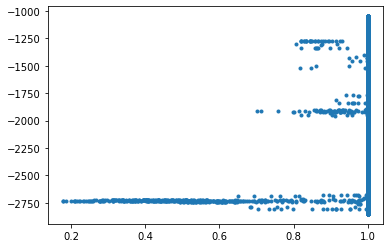

In [475]:
plt.plot(sub_logs['Water Saturation'],-sub_logs['Time'],  '.')

In [476]:
(sub_logs['Water Saturation']<0.9).sum(), sub_logs.shape[0]

(450, 49531)

2 additional well on proposed intervals don't have oil (Water Saturation==1). log'6507_5-5' has oil on 3230 up to 3266

In [477]:
logs[(logs['log_ID']=='6507_5-5') & (logs['Water Saturation']<1.0)]

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
75158,3230.0,2.6212,86.1755,0.0860,0.7564,0.9974,6507_5-5,NaN,225.883221
75159,3234.0,2.3672,79.2598,0.1682,0.0545,0.0815,6507_5-5,NaN,187.623799
75160,3238.0,2.3693,75.4672,0.1604,0.0602,0.0448,6507_5-5,NaN,178.804437
75161,3242.0,2.3687,75.4699,0.1601,0.0652,0.0504,6507_5-5,NaN,178.765552
75162,3246.0,2.4287,71.4300,0.1256,0.0670,0.1406,6507_5-5,NaN,173.482041
75163,3250.0,2.4472,71.0303,0.1153,0.0696,0.2849,6507_5-5,NaN,173.825350
75164,3254.0,2.3816,77.9391,0.1602,0.0745,0.2734,6507_5-5,NaN,185.619761
75165,3258.0,2.3854,77.4561,0.1585,0.0620,0.2992,6507_5-5,NaN,184.763781
75166,3262.0,2.4949,76.2368,0.0853,0.3599,0.9099,6507_5-5,NaN,190.203192
75167,3266.0,2.6242,71.8005,0.0526,0.3944,0.9964,6507_5-5,NaN,188.418872


### Moving average

In [478]:
features =stack_logs.columns.tolist()                         # creating a list of features
features.remove('log_ID')                                     # Removing log_ID as a feature
#stack_logs[stack_logs['log_ID']=='6507_2-1'][['Time', 'Stack']]
def opposite_mov_avg(data):
    
    data_1=(data+data.shift(1))/2
    data_1=data.append(data_1.dropna()).sort_values('Time').reset_index(drop=True)
    data_2=(data_1+data_1.shift(1))/2
    data_2=data_1.append(data_2.dropna()).sort_values('Time').reset_index(drop=True)
    return data_2

stack_logs_extra_points=opposite_mov_avg(stack_logs[stack_logs['log_ID']=='6507_2-1'][features])
#stack_logs_extra_points=opposite_mov_avg(stack_logs)
stack_logs_extra_points
#stack_logs
#stack_logs[stack_logs['log_ID']==log_id][['Time', 'Seismic']]

,Time,Seismic,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,0.0,-7.548390e-08,0.002513,0.000018,-5.314120e-07,-0.000959,-2.516130e-08,0.008822,20.0195,5.453330,0.000000,0.001618,-1.617760e-03,0.000693
1,1.0,-8.177418e-08,0.002471,0.000018,-5.588895e-07,-0.000951,-2.516130e-08,0.004422,20.0195,2.603595,0.000000,0.001582,-1.213345e-03,0.000368
2,2.0,-8.806445e-08,0.002428,0.000018,-5.863670e-07,-0.000943,-2.516130e-08,0.000022,20.0195,-0.246140,0.000000,0.001547,-8.089303e-04,0.000044
3,3.0,-9.435473e-08,0.002386,0.000018,-6.138445e-07,-0.000935,-2.516130e-08,-0.004377,20.0195,-3.095875,0.000000,0.001512,-4.045155e-04,-0.000281
4,4.0,-1.006450e-07,0.002343,0.000018,-6.413220e-07,-0.000927,-2.516130e-08,-0.008777,20.0195,-5.945610,0.000000,0.001476,-1.006450e-07,-0.000605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,3696.0,6.878200e-01,0.099278,0.006486,1.406940e-01,0.100497,-6.171700e-02,3.223610,24.4141,28.761200,-0.539050,0.112082,-1.120820e-01,0.020899
3697,3697.0,5.898730e-01,0.167429,0.007825,2.535495e-01,0.075077,-1.442345e-01,2.288616,24.4141,9.070900,-0.486805,0.086643,-8.664332e-02,0.015309
3698,3698.0,4.919260e-01,0.235581,0.009164,3.664050e-01,0.049657,-2.267520e-01,1.353623,24.4141,-10.619400,-0.434560,0.061205,-6.120465e-02,0.009719
3699,3699.0,3.939790e-01,0.303733,0.010503,4.792605e-01,0.024237,-3.092695e-01,0.418629,24.4141,-30.309700,-0.382315,0.035766,-3.576597e-02,0.004129


In [479]:

count=0
stack_logs_extra_points=[]
for log_id in stack_logs['log_ID'].value_counts().index.to_list():
    
    df_extra_points=opposite_mov_avg(stack_logs[stack_logs['log_ID']==log_id][features])
    df_extra_points['log_ID']=log_id
    
    if count==0:
        stack_logs_extra_points=df_extra_points
    else:
        stack_logs_extra_points=stack_logs_extra_points.append(df_extra_points)
    
    count=count+1

## Opposite Moving Average and Moving Average Implementation

In [480]:
opp_mov_avg=False
if opp_mov_avg==True:
    sub_logs['Time_rounded']=np.round(sub_logs['Time']/1)*1
    sub_logs=sub_logs.groupby(['log_ID','Time_rounded']).mean().reset_index().drop('Time', axis=1).rename(columns={'Time_rounded': 'Time'})
    sub_logs['Target']=0
    sub_logs.loc[sub_logs['Water Saturation']<=0.95, 'Target']=1
    
    log_seismic_df=pd.merge(sub_logs,stack_logs_extra_points, how='inner', on=['log_ID','Time']).sort_values(['log_ID','Time'])
    

else: 
    sub_logs_av = sub_logs
    sub_logs_av['Time_rounded'] = np.round(sub_logs_av['Time']/4)*4
    horison_vect = sub_logs_av.groupby(['log_ID','Time_rounded'])['Horison'].first().values
    sub_logs_av = sub_logs_av.groupby(['log_ID','Time_rounded']).mean()
    sub_logs_av['Horison'] = horison_vect
    sub_logs_av.reset_index(inplace=True)
    sub_logs_av.drop('Time',axis=1, inplace=True)
    sub_logs_av = sub_logs_av.rename(columns={'Time_rounded':'Time'})
    # Combining the sub_logs_avg and seismic dataframes picking only unique values of time and log_id present in the two dataframes
    log_seismic_df = pd.merge(sub_logs_av,stack_logs,on=['log_ID','Time'])

In [481]:
log_seismic_df['Target']=0
log_seismic_df.loc[log_seismic_df['Water Saturation']<=WS_level, 'Target']=1
log_seismic_df = log_seismic_df.dropna()
log_seismic_df = log_seismic_df[(log_seismic_df['Horison']=='2D-K65')|(log_seismic_df['Horison']=='2D-BCU')|(log_seismic_df['Horison']=='2D-mid2')]

<a id='split'></a>
## Split data into Train - Validation - Test
Test - one well

In [482]:
test_df=log_seismic_df[log_seismic_df['log_ID']=='6507_2-4']
train_df=log_seismic_df[~(log_seismic_df['log_ID']=='6507_2-4')]

In [483]:
train_df['log_ID'].value_counts()

6507_2-1     254
6507_2-2     253
6507_3-9S    237
Name: log_ID, dtype: int64

In [484]:
log_seismic_df

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,Target
196,6507_2-1,1836.0,1.865180,1995.942908,0.181788,0.674056,1.0,3727.971495,2D-mid2,-0.538545,...,-0.539715,1.855940,83.8727,20.1918,20.2535,0.789704,4.141150,4.141150,0.920176,0
197,6507_2-1,1840.0,1.919430,2072.824122,0.201115,0.647763,1.0,3981.194682,2D-mid2,1.540610,...,1.539570,2.079150,83.3950,20.2479,19.6154,0.223206,4.251510,4.251510,0.959941,0
198,6507_2-1,1844.0,2.050561,2191.257196,0.156904,0.701825,1.0,4495.013770,2D-mid2,3.311070,...,3.310560,1.770460,85.2538,20.3071,19.5134,-0.308686,4.368980,4.368980,0.989039,0
199,6507_2-1,1848.0,2.064218,2227.875786,0.157536,0.687446,1.0,4612.202204,2D-mid2,4.427660,...,4.427610,1.116590,92.2328,20.3693,20.3720,-0.653875,4.527420,4.527420,1.003076,0
200,6507_2-1,1852.0,2.040321,2271.261386,0.230897,0.600286,1.0,4653.714379,2D-mid2,4.434920,...,4.434800,0.007255,98.1797,20.4346,21.0747,-1.109330,4.658660,4.658660,1.014800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,6507_3-9S,2772.0,2.462435,2821.728600,0.159973,0.727278,1.0,6948.195398,2D-K65,-0.585401,...,-0.585008,-0.388663,17.0488,29.2969,17.0910,-0.045212,0.997527,-0.997527,0.241291,0
1737,6507_3-9S,2776.0,2.435376,2818.600397,0.175062,0.705462,1.0,6864.353695,2D-K65,-0.892463,...,-0.892323,-0.307061,18.1421,29.2969,17.8150,0.081602,1.018360,-1.018360,0.241273,0
1738,6507_3-9S,2780.0,2.471103,2812.135657,0.158430,0.739238,1.0,6949.902279,2D-K65,-0.987688,...,-0.987687,-0.095226,18.1957,29.2969,18.3990,0.211836,0.988954,-0.988954,0.230557,0
1739,6507_3-9S,2784.0,2.452608,2785.768038,0.165576,0.699203,1.0,6832.026304,2D-K65,-0.827980,...,-0.827870,0.159708,19.1803,29.2969,20.9444,0.254934,0.915771,-0.915771,0.200103,0


In [485]:
test_df['log_ID'].value_counts()

6507_2-4    255
Name: log_ID, dtype: int64

In [486]:
(log_seismic_df['Target'])

196     0
197     0
198     0
199     0
200     0
       ..
1736    0
1737    0
1738    0
1739    0
1740    0
Name: Target, Length: 999, dtype: int64

In [487]:
features = ['Density', 'P_wave','Imp','Sweetness','Seismic','AmpEnv']
X=train_df[features]
Y=train_df['Target']

X_test=test_df[features]
y_test=test_df['Target']

## SMOTE IMPLEMENTATION

In [488]:

if (imbalance == True):
    ros = RandomOverSampler(random_state=42)
    #SM = SMOTE()
    #X,Y = SM.fit_resample(X,Y)
    #SM = SMOTE(random_state=42)
    #smt = SMOTETomek(random_state=42)
    sme = SMOTEENN(random_state=42)
    #X,Y = SM.fit_resample(X,Y)    #Implementing smote
    #X,Y = smt.fit_resample(X,Y)
    X,Y = sme.fit_resample(X,Y)
    #X,Y = ros.fit_resample(X,Y)

In [489]:
xList = []
for i in X.index.to_list():
    
    if i not in train_df.index.to_list():
        xList.append(i)
        #print(i)
#print(xList)
X = X.drop(xList) # Removing data points generated by Smote Algorithm not in original data index this removes unrealistic points if you consider geology

yList = []
for i in Y.index.to_list():
    
    if i not in train_df.index.to_list():
        yList.append(i)
        #print(i)
#print(yList)
Y = Y.drop(yList) # Removing data points generated by Smote Algorithm not in original data index this removes unrealistic points if you consider geology


In [490]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

In [491]:
# find numerical and catoegorical column names
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
print (numerical_ix)
print (categorical_ix)

Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'Seismic', 'AmpEnv'], dtype='object')
Index([], dtype='object')


In [492]:
#sub_logs[y_train.index.to_list()]
#y_train.index.to_list()
y_train[(y_train==0)]

312    0
241    0
212    0
659    0
199    0
      ..
267    0
302    0
569    0
647    0
298    0
Name: Target, Length: 290, dtype: int64

### Functions for visializing the results

In [493]:
def prec_recall_report(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary')        
    print ('Precision: ', prec)
    print ('Recall: ', recall)
    print ('F-score: ', fscore)

In [494]:
def f1_score_eval(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary') 
    return fscore

In [495]:
def prec_recall_fscore_train_val_test(clf, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred=clf.predict(X_train)
    y_val_pred=clf.predict(X_val)
    y_test_pred=clf.predict(X_test)

    print ('Precision/ Recall/ F-score on train set : \n')
    prec_recall_report(y_train, y_train_pred)

    if (X_train.shape!=X_val.shape) or ~(X_train==X_val).all().all():
        print ('\n Precision/ Recall/ F-score on validation set : \n')
        prec_recall_report(y_val, y_val_pred)

    print ('\n Precision/ Recall/ F-score on test set : \n')
    prec_recall_report(y_test, y_test_pred)

    
    return y_train_pred, y_val_pred, y_test_pred

In [496]:
def real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, title_text, logs=train_df, logs_4=test_df):
    fig, ax = plt.subplots(1,3,figsize=(15,8))


    #plot y_train Vs y_train_pred 
    ax[0].plot(y_train,-logs.loc[X_train.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[0].plot(y_train_pred+0.015,-logs.loc[y_train.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[0].legend(['original', 'predicted']);
    ax[0].set_xlabel('1-oil / 0-otherwise');
    ax[0].set_ylabel('Time');
    ax[0].set_title('train set'); 
    
    
    ax[1].plot(y_val,-logs.loc[X_val.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[1].plot(y_val_pred+0.015,-logs.loc[y_val.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[1].legend(['original', 'predicted']);
    ax[1].set_xlabel('1-oil / 0-otherwise');
    ax[1].set_ylabel('Time');
    ax[1].set_title('validation set'); 
     
    #plot y_test VS y_test_pred
    ax[2].plot(y_test,-logs_4['Time'], 'b.' , alpha=0.5)
    ax[2].plot(y_test_pred+0.015,-logs_4['Time'], 'r.' , alpha=0.5)
    ax[2].legend(['original', 'predicted']);
    ax[2].set_title('test set');    
    ax[2].set_xlabel('1-oil / 0-otherwise');
    
    fig.suptitle(title_text, fontsize=16)

In [497]:
def predict_section(df1, method_name, method, features=features):
    df1['Pred']=method.predict(df1[features])

    df2=df1[['Trace','Time', 'Pred']].groupby(['Time', 'Trace'])['Pred'].aggregate('first').unstack()
    plt.figure(figsize=(20, 5))
    plt.title (method_name)
    ax = sb.heatmap(df2,vmin=0, vmax=1, cmap="YlGnBu")

In [498]:
def output_function(clf, clf_name, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(clf, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
    
    real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, clf_name)
    predict_section(section_stack_df[(section_stack_df['Time'] >1050) & (section_stack_df['Horison']=='2D-K65') | 
              (section_stack_df['Time'] >1050) &(section_stack_df['Horison']=='2D-mid2')].dropna(), '2D section1 - '+clf_name ,  clf )
        



In [499]:
def grid_search_function(clf, parameters, X_train, y_train):
    
    cv = GridSearchCV(clf,  param_grid=parameters, scoring = 'f1')
    cv.fit(X_train, y_train)
    print (cv.best_params_)
    
    return cv


In [500]:
def kfold_gridsearch_function(clf, parameters, X, Y, K_folds):
    
    cv= RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=3, random_state=1)
    search = GridSearchCV(clf, parameters, scoring='f1', n_jobs=-1, cv=cv)
    result = search.fit(X, Y)
    print('Best Hyperparameters: %s' % result.best_params_, '\n')
    print('Mean test score: %s' % result.best_score_, '\n')
    print('Std test score: %s' % result.cv_results_['std_test_score'][result.cv_results_['rank_test_score']==1].tolist()[0], '\n')
    
    return result

<a id='pipeline'></a>
## Build pipeline

### Columns transformation

In [501]:
# categorical columns -> One Hot Encoding 
# numerical column -> Scaling
t = [('cat', OneHotEncoder(drop='first'), categorical_ix), 
     ('num',StandardScaler(), numerical_ix)]

col_transform = ColumnTransformer(transformers=t)

## Define algorithms and hyper parameters

In [502]:
# Logistic regression
log_reg = Pipeline([
    ('prep',col_transform), 
    ('clf', LogisticRegression(random_state=42))
    ])

log_reg_params = {
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'clf__penalty':['l2','elasticnet'],
        'clf__C':[100, 10, 1.0, 0.1, 0.01],
        'clf__random_state': [42],
        'clf__multi_class': ['auto'],

    }
## ------------------------------------------------------------------
# Gaussian Naive Bayes 
gnb = Pipeline([
    ('prep',col_transform), 
    ('clf', GaussianNB())
    ])

gnb_params= {
        'clf__var_smoothing': [0.00000001, 0.000000001]
    }
## ------------------------------------------------------------------
# Support Vector Machine
svm=Pipeline([
    ('prep',col_transform), 
    ('clf', SVC(random_state=42))
    ])

svm_params = {
        'clf__kernel':['poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale'],
        'clf__C':[50, 10, 1.0, 0.1, 0.01]
    }
## ------------------------------------------------------------------
# Gradient boosting classifier 
gbc=Pipeline([
    ('prep',col_transform), 
    ('clf', GradientBoostingClassifier(random_state=42))
    ])

gbc_params = {
        'clf__n_estimators': [10, 100, 1000],
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__subsample':[0.5, 0.7, 1.0], 
        'clf__max_depth': [3, 7, 9]
    }
## ------------------------------------------------------------------
# Multi-layer Perceptron classifier
mlpc= Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier())
     ])

mlpc_params = {
    'clf__hidden_layer_sizes': [(50), (150,)], 
    'clf__activation': ['tanh', 'relu'], 
    'clf__solver': ['sgd', 'adam'], 
    'clf__alpha': [0.0001, 0.05],
    'clf__learning_rate': ['constant','adaptive'],
    'clf__random_state':[42],

}

## 1 Logistic regression 

### 1.1 No parameters tuning

In [503]:
log_reg.fit(X_train, y_train);

Precision/ Recall/ F-score on train set : 

Precision:  0.9074074074074074
Recall:  0.765625
F-score:  0.8305084745762712

 Precision/ Recall/ F-score on validation set : 

Precision:  0.90625
Recall:  0.7631578947368421
F-score:  0.8285714285714286

 Precision/ Recall/ F-score on test set : 

Precision:  0.5714285714285714
Recall:  1.0
F-score:  0.7272727272727273


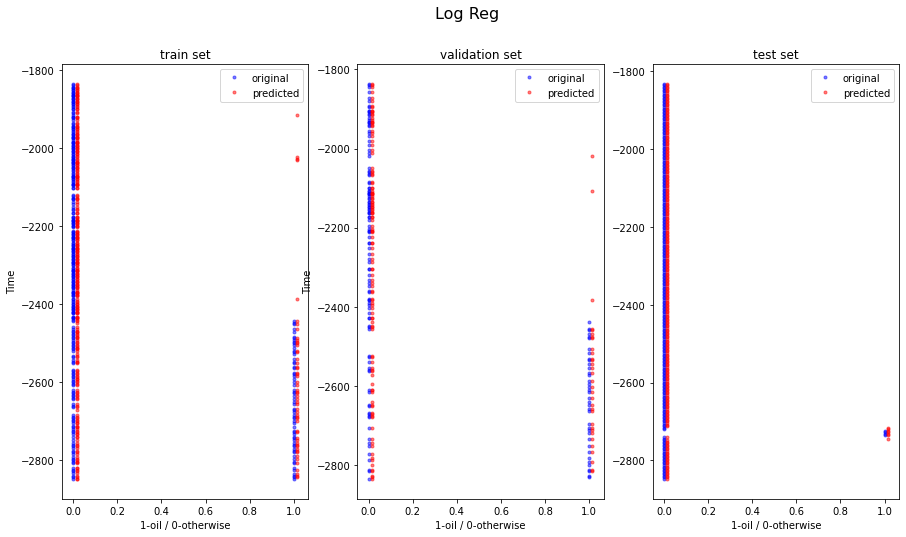

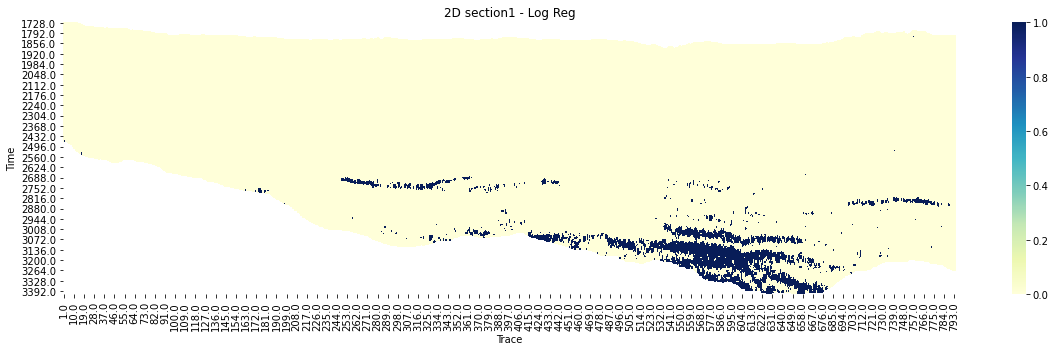

In [504]:
output_function(log_reg, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)

### 1.2 Grid Search for Hyperparameters tuning on Train / Validation / Test (Logistic regression) 

{'clf__C': 100, 'clf__multi_class': 'auto', 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg'}
Precision/ Recall/ F-score on train set : 

Precision:  0.9830508474576272
Recall:  0.90625
F-score:  0.943089430894309

 Precision/ Recall/ F-score on validation set : 

Precision:  0.9428571428571428
Recall:  0.868421052631579
F-score:  0.904109589041096

 Precision/ Recall/ F-score on test set : 

Precision:  0.8
Recall:  1.0
F-score:  0.888888888888889


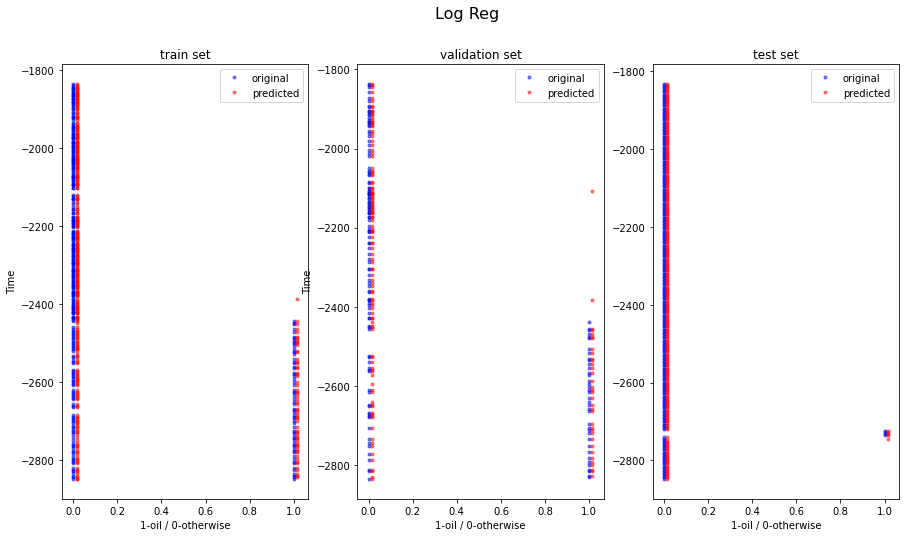

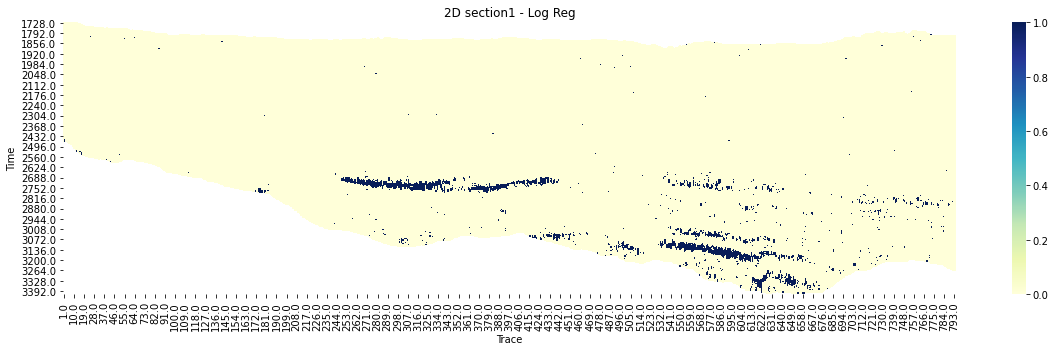

In [505]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(log_reg, log_reg_params, X_train, y_train)
    output_function(cv, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 1.3 KFold and Grid Search (Logistic Regression)

Best Hyperparameters: {'clf__C': 100, 'clf__multi_class': 'auto', 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg'} 

Mean test score: 0.9252085328850412 

Std test score: 0.029404107886217057 

Precision/ Recall/ F-score on train set : 

Precision:  0.9680851063829787
Recall:  0.8921568627450981
F-score:  0.9285714285714286

 Precision/ Recall/ F-score on test set : 

Precision:  0.8
Recall:  1.0
F-score:  0.888888888888889


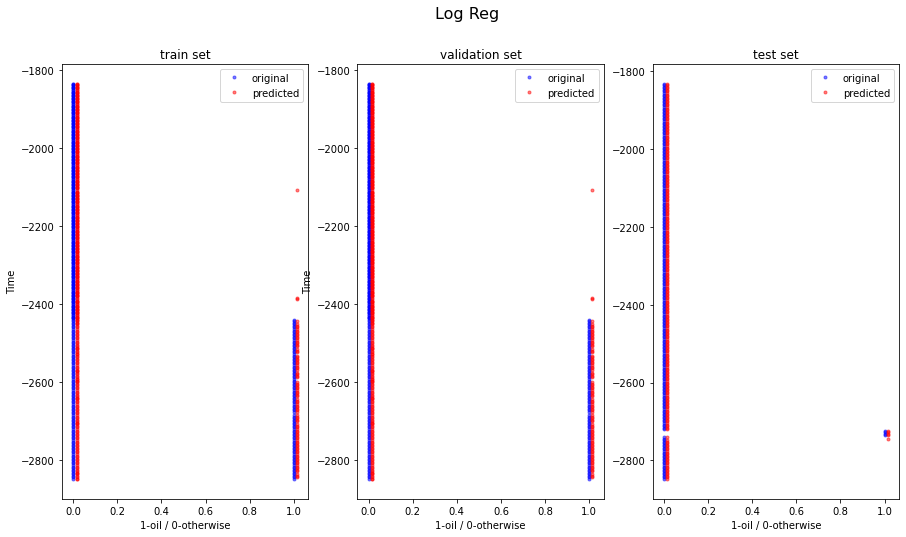

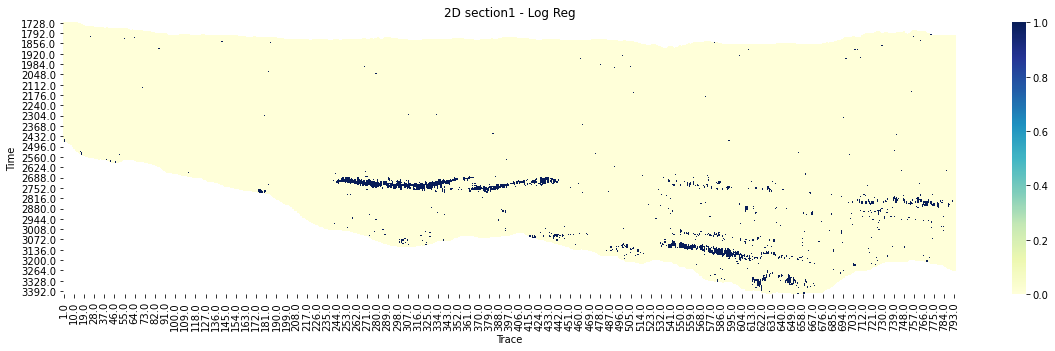

In [506]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(log_reg, log_reg_params, X, Y, K_folds)
    output_function(result, 'Log Reg', X, Y, X, Y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 2. Gaussian Naive Bayes

### 2.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  0.8923076923076924
Recall:  0.90625
F-score:  0.8992248062015504

 Precision/ Recall/ F-score on validation set : 

Precision:  0.925
Recall:  0.9736842105263158
F-score:  0.9487179487179489

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


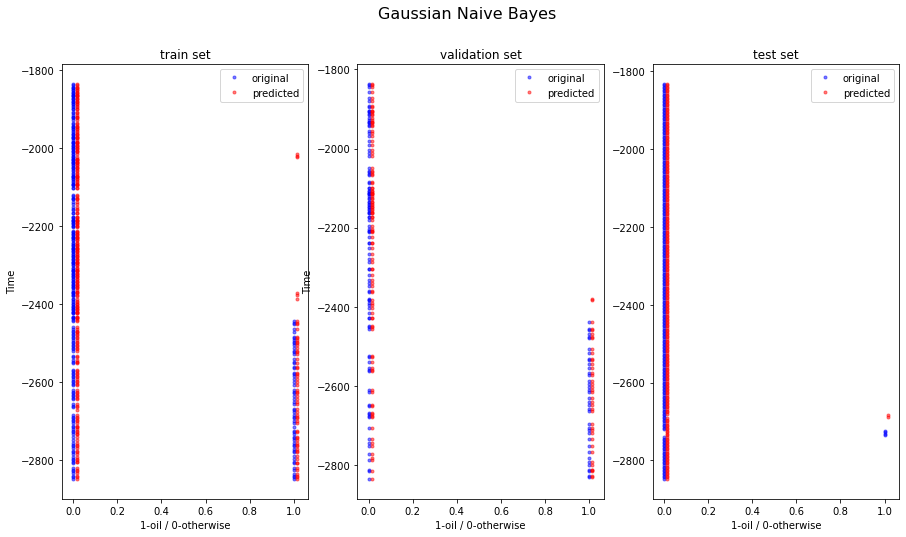

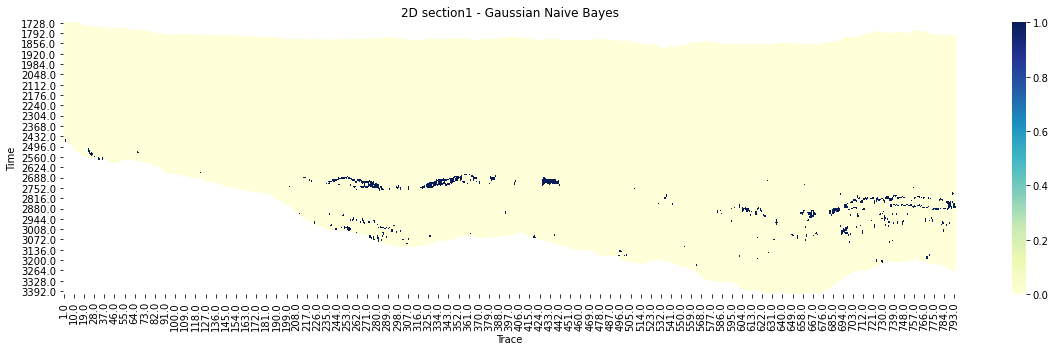

In [507]:
gnb.fit(X_train, y_train)
output_function(gnb, 'Gaussian Naive Bayes', X_train, y_train, X_val, y_val, X_test, y_test)

### 2.2 Grid search for Gaussian Naive Bayes hyperparams on Train/ Validation / Test

{'clf__var_smoothing': 1e-08}
Precision/ Recall/ F-score on train set : 

Precision:  0.8923076923076924
Recall:  0.90625
F-score:  0.8992248062015504

 Precision/ Recall/ F-score on validation set : 

Precision:  0.925
Recall:  0.9736842105263158
F-score:  0.9487179487179489

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


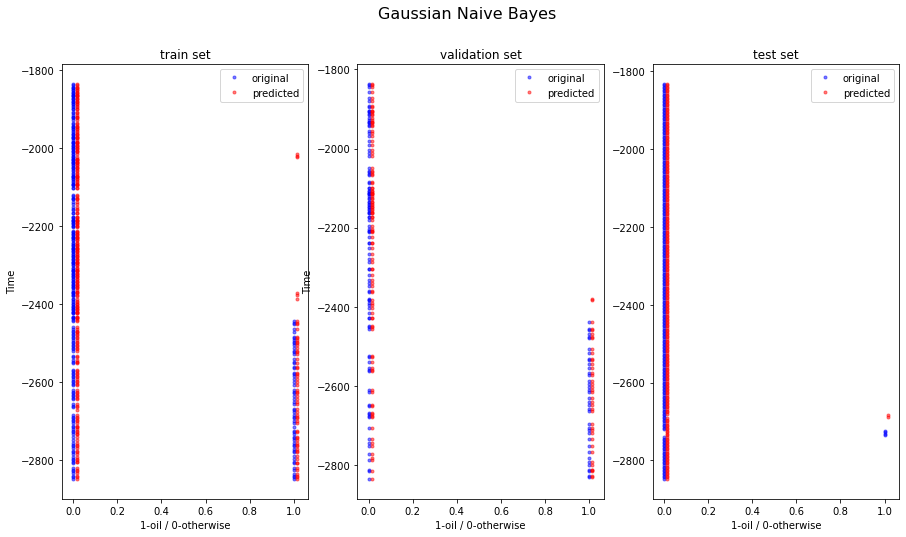

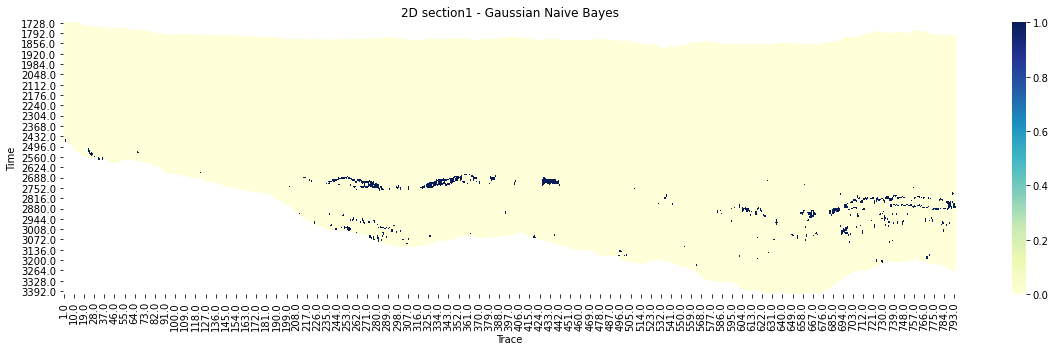

In [508]:
make_gridsearch=True
if make_gridsearch==True:
    cv=grid_search_function(gnb, gnb_params,X_train, y_train)
    output_function(cv, 'Gaussian Naive Bayes', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'gnb_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 2.3 Kfold+GridSEarch (Gaussian Naive Bayes)

Best Hyperparameters: {'clf__var_smoothing': 1e-08} 

Mean test score: 0.9088869556239768 

Std test score: 0.03563600573780739 

Precision/ Recall/ F-score on train set : 

Precision:  0.9047619047619048
Recall:  0.9313725490196079
F-score:  0.9178743961352657

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


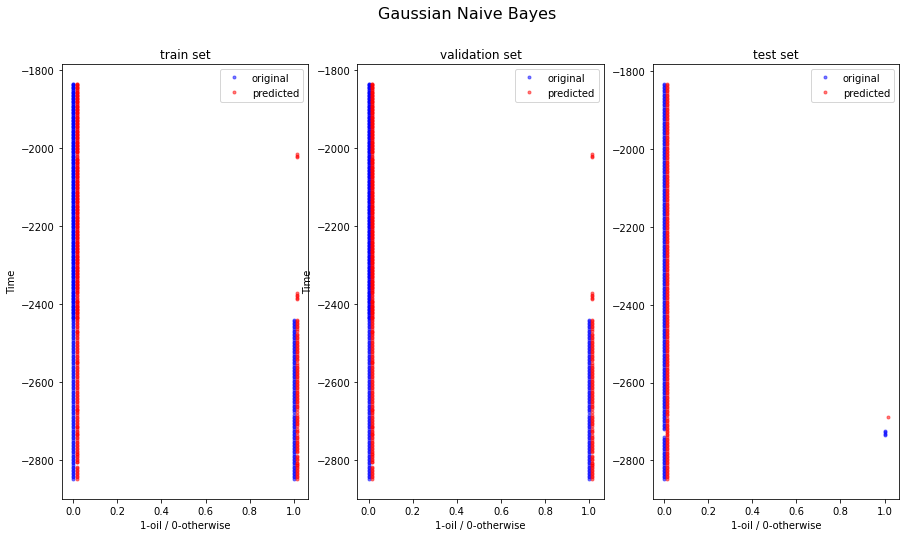

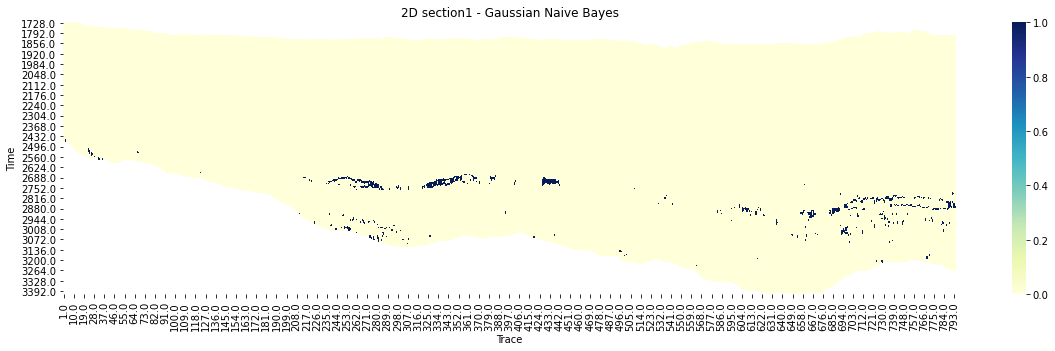

In [509]:
make_kfold=True
if make_kfold==True:
    result=kfold_gridsearch_function(gnb, gnb_params, X, Y, K_folds)
    output_function(result, 'Gaussian Naive Bayes', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'gnb_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 3. Support Vector Machine

### 3.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  0.972972972972973
Recall:  0.9473684210526315
F-score:  0.9599999999999999

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.5
F-score:  0.6666666666666666


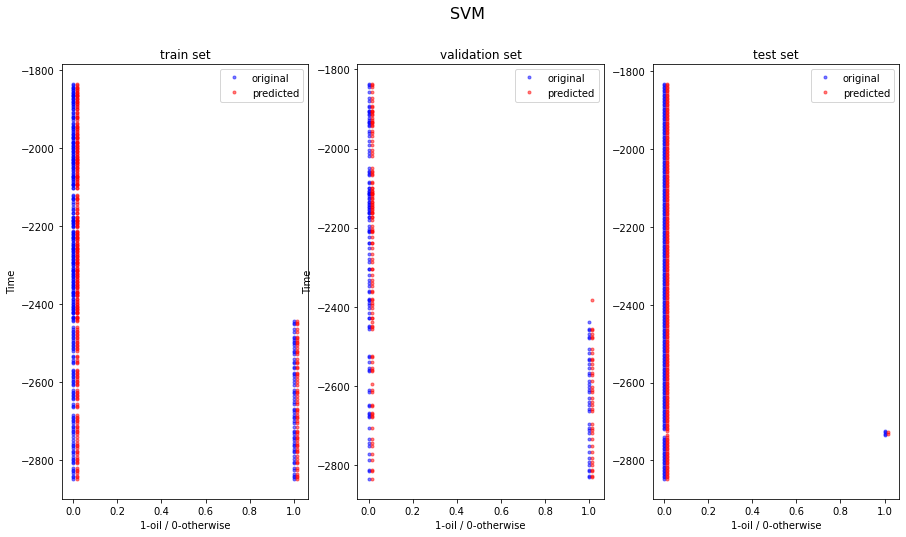

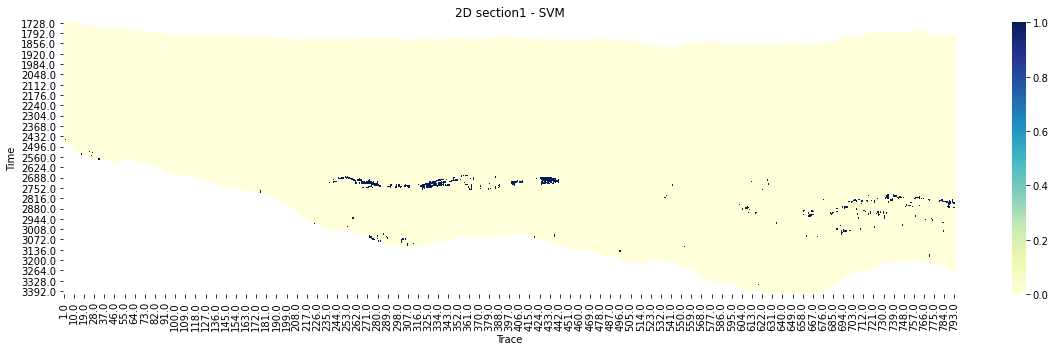

In [510]:
svm.fit(X_train, y_train)
output_function(svm, 'SVM', X_train, y_train, X_val, y_val, X_test, y_test)

### 3.2 Grid search SVM (Train/Validation/Test)

{'clf__C': 1.0, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  0.972972972972973
Recall:  0.9473684210526315
F-score:  0.9599999999999999

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.5
F-score:  0.6666666666666666


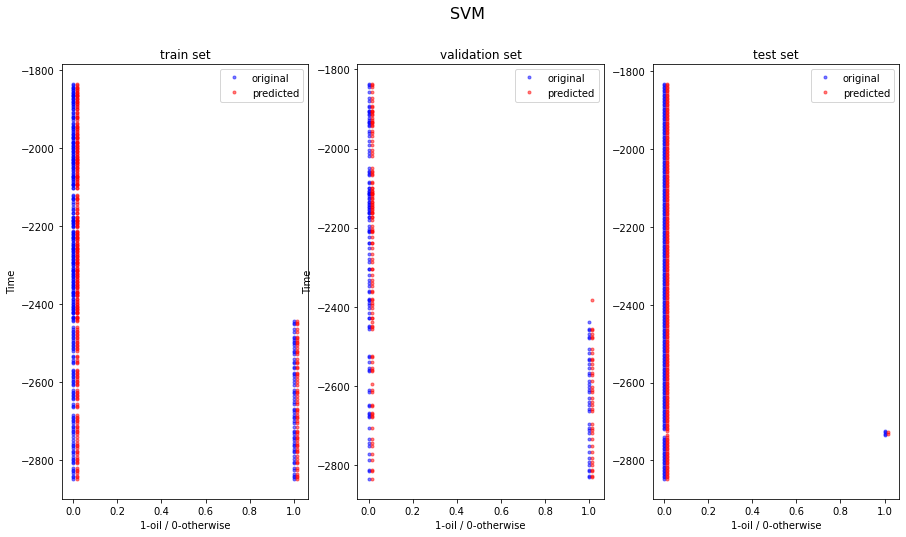

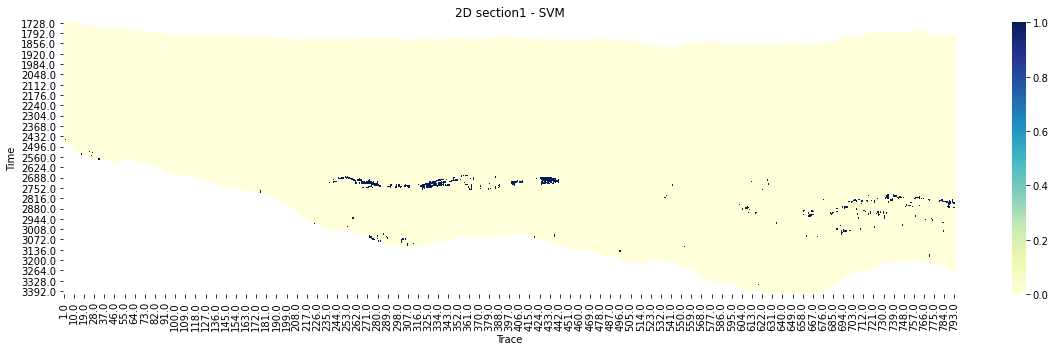

In [511]:
if make_gridsearch==True:
    cv=grid_search_function(svm, svm_params, X_train, y_train)
    output_function(cv, 'SVM', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'svm_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 3.3. Kfold + GridSearch on SVM

Best Hyperparameters: {'clf__C': 50, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'} 

Mean test score: 0.9825624366180236 

Std test score: 0.013408676508423692 

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


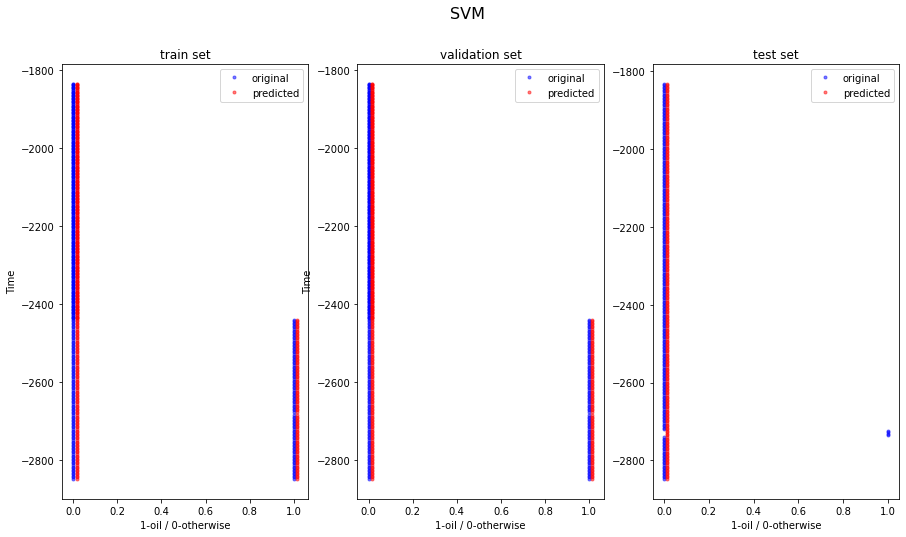

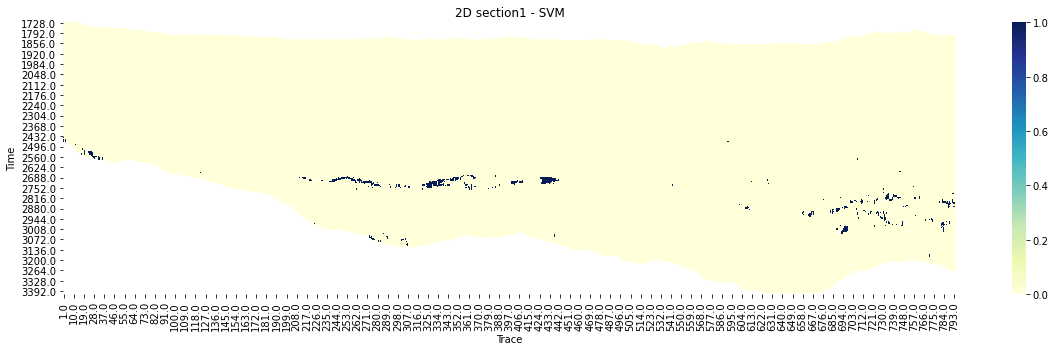

In [512]:
if make_kfold==True:
    result=kfold_gridsearch_function(svm, svm_params, X, Y, K_folds)
    output_function(result, 'SVM', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'svm_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 4. Gradient Boosting clf

### 4.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


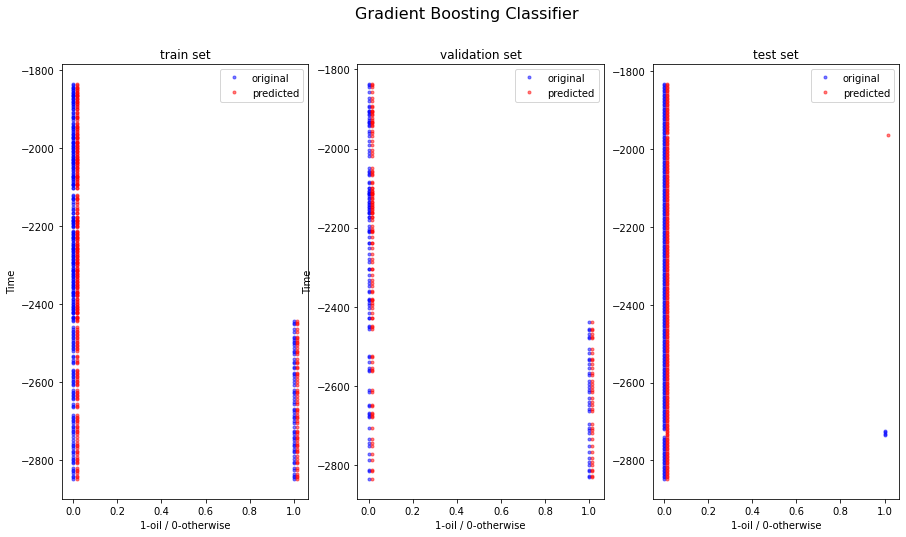

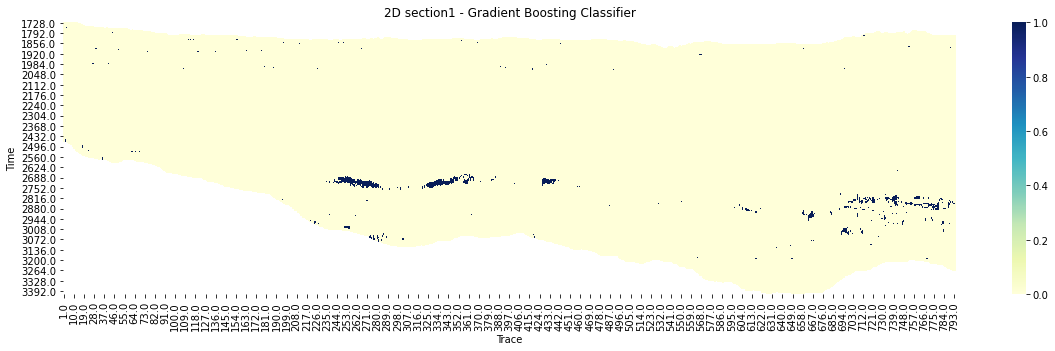

In [513]:
gbc.fit(X_train, y_train)
output_function(gbc, 'Gradient Boosting Classifier', X_train, y_train, X_val, y_val, X_test, y_test)

### 4.2 Grid Search for Gradient Boosting clf (Train/Validation/Test)

{'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 1000, 'clf__subsample': 0.5}
Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


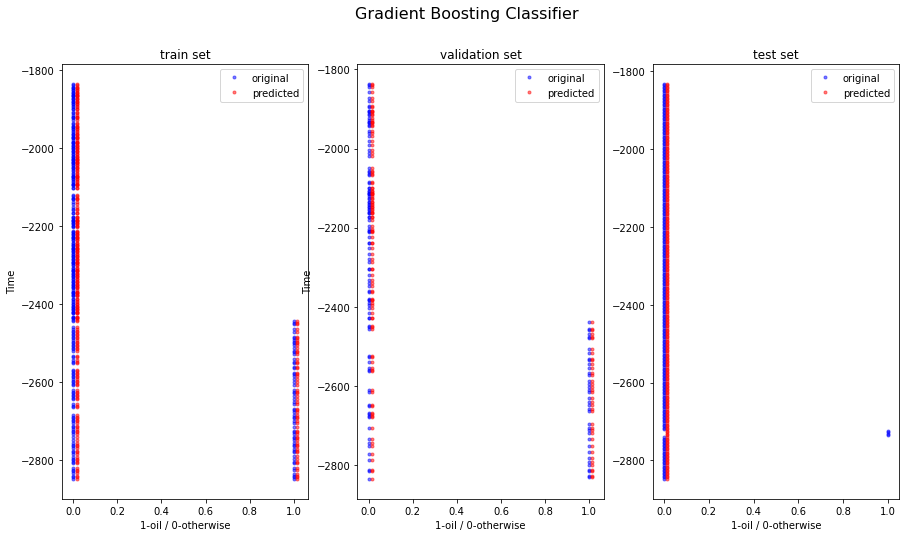

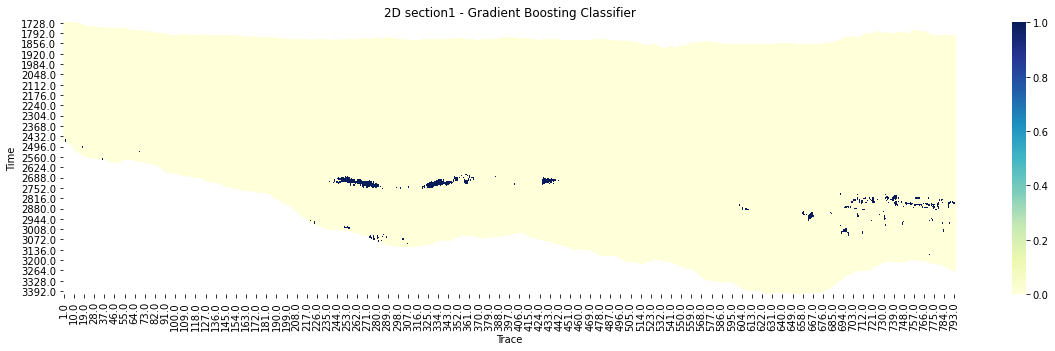

In [514]:
if make_gridsearch==True:
    cv=grid_search_function(gbc, gbc_params, X_train, y_train)
    output_function(cv, 'Gradient Boosting Classifier', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'gbc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 4.3 Kfold + Grid Search (  Gradient Boosting Classifier)

Best Hyperparameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 1000, 'clf__subsample': 1.0} 

Mean test score: 0.9932478632478632 

Std test score: 0.014447731381441004 

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  0.0
Recall:  0.0
F-score:  0.0


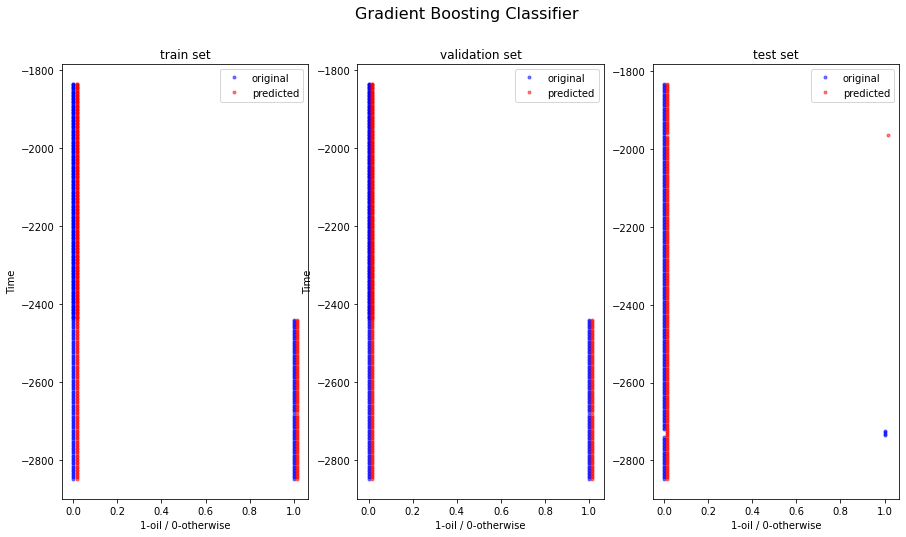

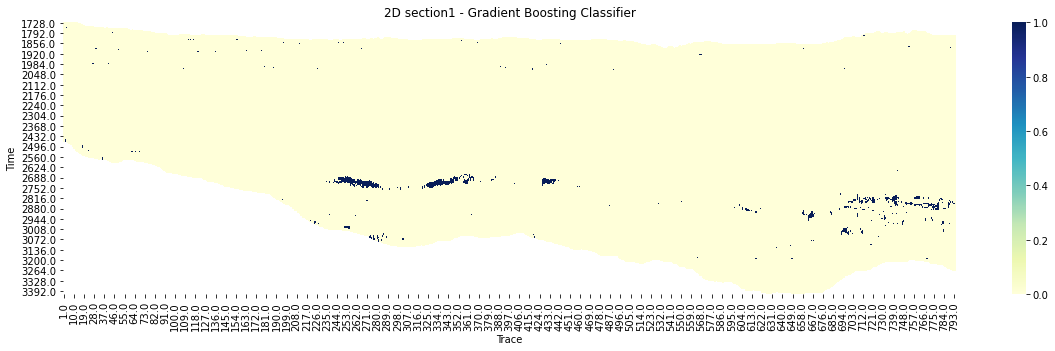

In [515]:
if make_kfold==True:
    result=kfold_gridsearch_function(gbc, gbc_params, X, Y, K_folds)
    output_function(result, 'Gradient Boosting Classifier', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'gbc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 5. MLPClassifier (Neural Network)

### 5.1 No parameters tuning

In [516]:
mlpc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Imp', 'Sweetness', 'Seismic', 'AmpEnv'], dtype='object'))])),
                ('clf', MLPClassifier())])

Precision/ Recall/ F-score on train set : 

Precision:  0.9846153846153847
Recall:  1.0
F-score:  0.9922480620155039

 Precision/ Recall/ F-score on validation set : 

Precision:  0.9487179487179487
Recall:  0.9736842105263158
F-score:  0.9610389610389611

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.5
F-score:  0.6666666666666666


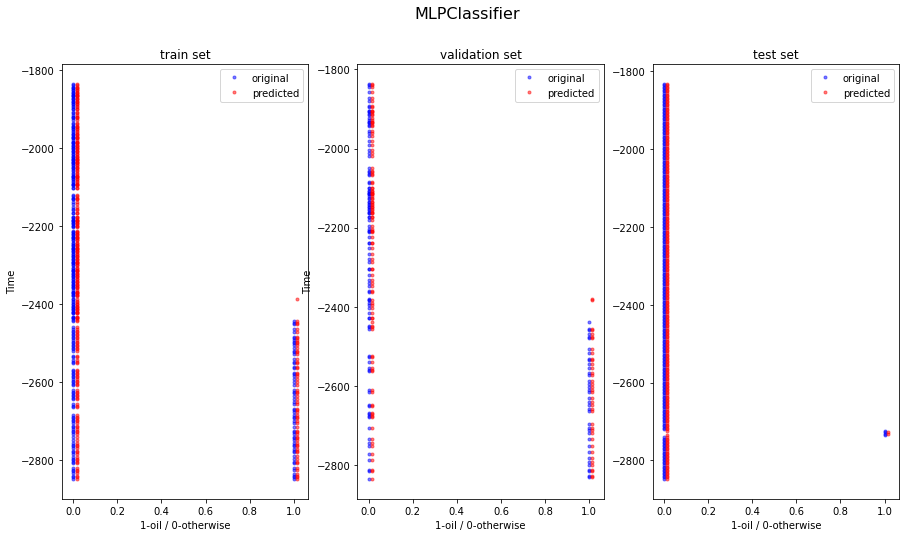

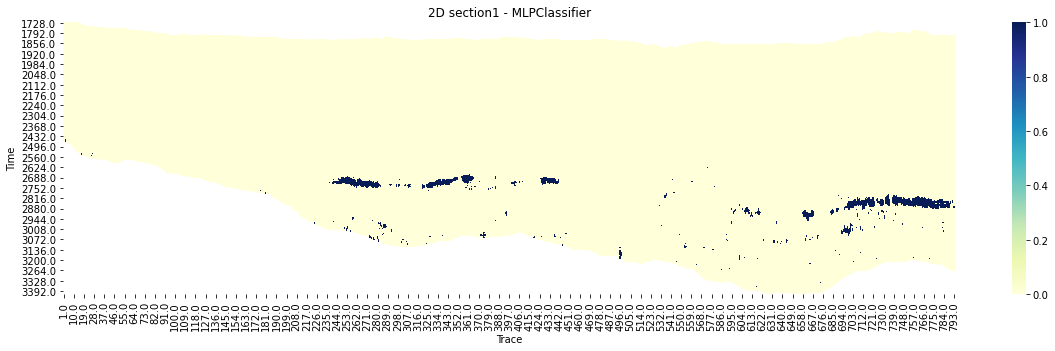

In [517]:
output_function(mlpc, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

### 5.2 Grid Search MLPC (Train/ Validation/ test)

{'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': 50, 'clf__learning_rate': 'constant', 'clf__random_state': 42, 'clf__solver': 'adam'}
Precision/ Recall/ F-score on train set : 

Precision:  0.9696969696969697
Recall:  1.0
F-score:  0.9846153846153847

 Precision/ Recall/ F-score on validation set : 

Precision:  0.9473684210526315
Recall:  0.9473684210526315
F-score:  0.9473684210526315

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.25
F-score:  0.4


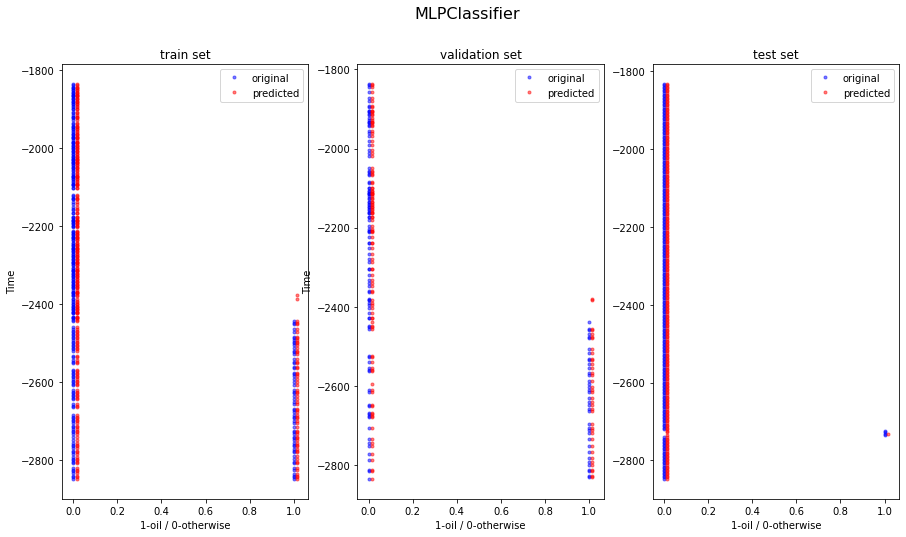

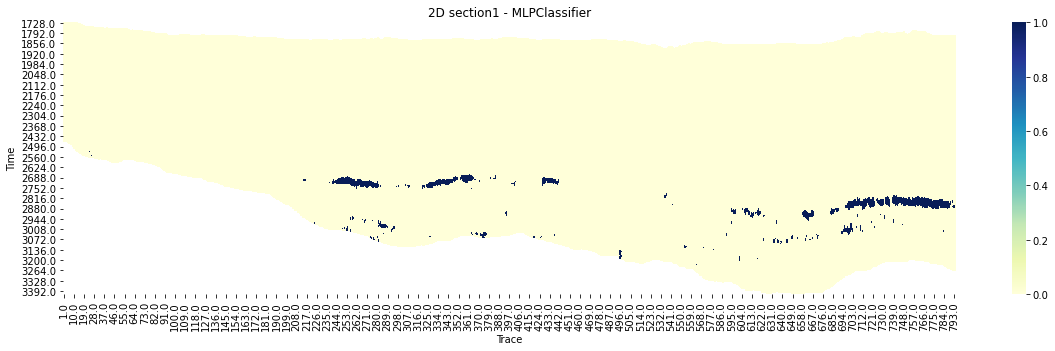

In [518]:
if make_gridsearch==True:
    cv=grid_search_function(mlpc, mlpc_params, X_train, y_train)
    output_function(cv, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

    #save model to file
    filename = 'mlpc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 5.3 Kfold + Grid Search (MLP classifier)

Best Hyperparameters: {'clf__activation': 'relu', 'clf__alpha': 0.05, 'clf__hidden_layer_sizes': 50, 'clf__learning_rate': 'constant', 'clf__random_state': 42, 'clf__solver': 'adam'} 

Mean test score: 0.9723194691487377 

Std test score: 0.02184357757479877 

Precision/ Recall/ F-score on train set : 

Precision:  0.9711538461538461
Recall:  0.9901960784313726
F-score:  0.9805825242718447

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.5
F-score:  0.6666666666666666


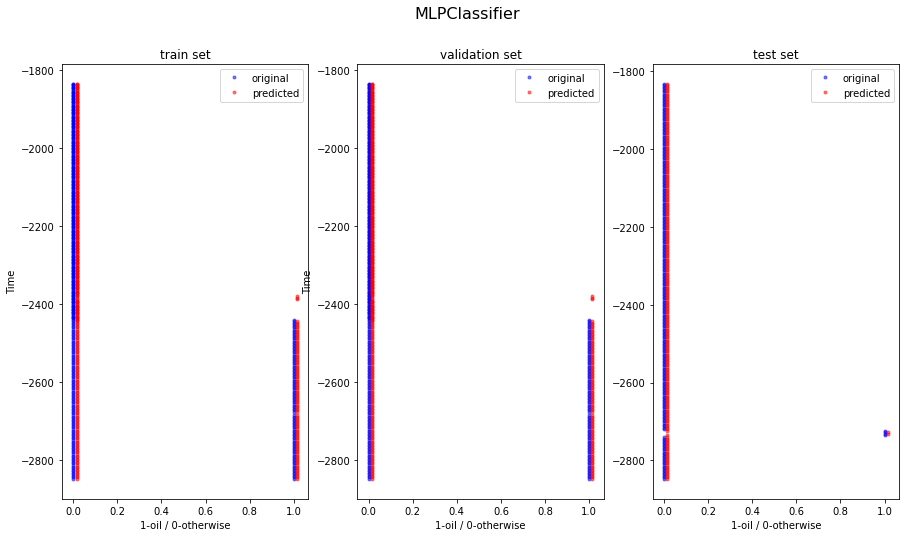

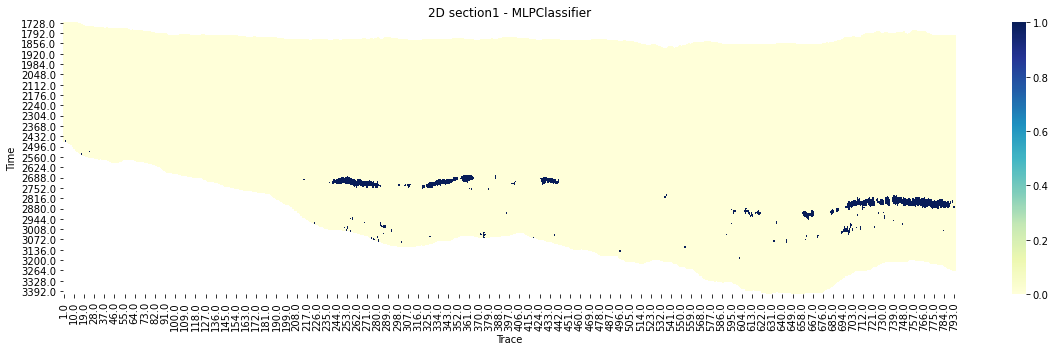

In [519]:
make_kfold=True
if make_kfold==True:
    result=kfold_gridsearch_function(mlpc, mlpc_params, X, Y, K_folds)
    output_function(result, 'MLPClassifier', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'mlpc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))